# Redes neuronales sencillas

En este notebook exploraremos la creación de una red neuronal de "capas densas". Utilizaremos dicha red para resolver el problema de clasificación de números escritos a mano!

La librería que nos permitirá crear la red se llama [tensorflow](https://www.tensorflow.org/?hl=es-419).

In [1]:
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models, losses
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

Tensorflow ya tiene algunos datasets clásicos de Machine Learning, entre ellos se encuentra la base de datos MNIST.
Esta tiene un montón de imágenes de números que personas escribieron a mano.

In [2]:
# Descargamos la base de datos!
mnist_data = tfds.load("mnist")

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [3]:
# Transformaremos el formato de los datos para trabahar de forma más cómoda.
# En este caso, directamente utilizaremos arreglos de numpy :)
arr_data = []
arr_labels = []
for example in tfds.as_numpy(mnist_data['train']):
  image, label = example['image'], example['label']
  arr_data.append(image)
  arr_labels.append(label)

for example in tfds.as_numpy(mnist_data['test']):
  image, label = example['image'], example['label']
  arr_data.append(image)
  arr_labels.append(label)

Es extremadamente importante enteder los datos con los que uno está trabajando.
Para ello visualizaremos algunos números de la base de datos.

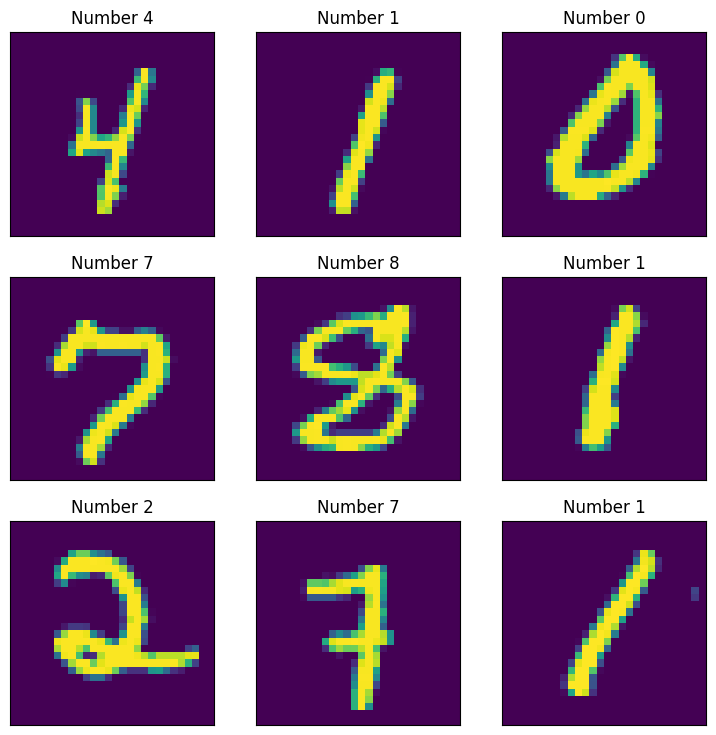

In [4]:
i = 0
plt.figure(figsize=(9,9))

for example in tfds.as_numpy(mnist_data['train']):
  image, label = example['image'], example['label']
  plt.subplot(3,3,i+1)
  plt.imshow(image)
  plt.title(f'Number {label}')
  plt.xticks([])
  plt.yticks([])
  i += 1
  if i > 8:
    break

Como vimos en clases, esto corresponde a un problema de clasificación múltiple.
Tenemos 2 alternativas para lidiar con los "labels" de las imágenes, trabajarlos como enteros directamente o utilizar "one-hot encoding". Utilizaremos lo último ya que es más amigable con la arquitectura de la red que crearemos.

In [7]:
arr_data = np.array(arr_data)
OHE = OneHotEncoder()

OHE.fit(np.array(arr_labels).reshape(-1,1))
one_hot_labels = OHE.transform(np.array(arr_labels).reshape(-1,1)).toarray()

In [9]:
# Ejemplo de como función en OHE
OHE.transform(np.array([6]).reshape(-1,1)).toarray(),  OHE.transform(np.array([2]).reshape(-1,1)).toarray()

(array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]]),
 array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]]))

Con TensorFlow podemos crear redes neuronales como si estuvieramos armando legos, vamos capa por capa.

In [10]:
model = models.Sequential()
model.add(layers.InputLayer(shape=(28,28)))       # le indicamos a la red como es la entrada, una imagen de 28X28 pixeles.
model.add(layers.Flatten())                       # la red no trabaja con imágenes, por lo que debemos transformalo a arreglos 1D

model.add(layers.Dense(64, activation='relu'))    # añadimos la primera capa oculta con 64 neuronas, función de activación RELU

model.add(layers.Dense(128, activation='relu'))   # 2da capa oculta de 128 neuronas, función de activación RELU

model.add(layers.Dense(64, activation='relu'))    # 3era capa oculta de 64 neuronas, función de activación RELU

model.add(layers.Dense(10, activation='softmax')) #

En general no hay "reglas" sobre cuantas capas o neuronas uno debe utilizar, solo indicaciones generales (existen excepciones como verán en las redes convolucionales).

Por lo general mientras más profunda la red se desempeña mejor, pero también es más fácil "overfittear" porque la cantidad de parámetros aumenta muy rápido, por lo que debe existir un balance. También pueden existir limitaciones computacionales, quizá no tengo un computador que pueda entrenar redes de millones de parámetros.

In [11]:
model.compile(optimizer='adam', loss=losses.CategoricalCrossentropy())

La función de costos aquí es la entropía cruzada pero generalizada para un problema de clasificación múltiple. En la documentación de dicha función de costos se puede notar que trabaja exclusivamente con One-hot encoding.

El optimizador podría ser descenso del gradiente tradicional, pero existen versiones refinadas como ADAM, las cuales hacen uso de estrategias adaptativas para lidiar con la tasa de aprendizaje de forma óptima y que esta deje de ser un "híper parámetro".

Antes de entrenar la red nos falta separar adecuadamente nuestro dataset.
Para ello dejaremos 50000 datos para entrenar, 10000 para validación

In [12]:
arr_data.shape

(70000, 28, 28, 1)

In [13]:
data_training = arr_data[:50000]
labels_training = one_hot_labels[:50000]

data_validation = arr_data[50000:60000]
labels_validation = one_hot_labels[50000:60000]

data_test = arr_data[60000:]
labels_test = one_hot_labels[60000:]

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

In [17]:
cp = EarlyStopping(patience= 5)  # Usaremos early stopping, el parámetro "patience" es la tolerancia en iteraciones antes de parar.

In [ ]:
model.summary()  # trate de calcular el número de parámetros por su cuenta!

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │          50,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 202,400 (790.63 KB)

 Trainable params: 67,466 (263.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 134,934 (527.09 KB)

In [20]:
history = model.fit(data_training, labels_training, epochs=30,  validation_data=(data_validation, labels_validation),callbacks=cp)

Epoch 1/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 2.8367 - val_loss: 0.3348
Epoch 2/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.2671 - val_loss: 0.2153
Epoch 3/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.1964 - val_loss: 0.1972
Epoch 4/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 0.1496 - val_loss: 0.1868
Epoch 5/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.1330 - val_loss: 0.2202
Epoch 6/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.1166 - val_loss: 0.1785
Epoch 7/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.1068 - val_loss: 0.1446
Epoch 8/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0943 - val_loss: 0.1793
Epoch 9/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0882 - val_loss: 0.1572
Epoch 10/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0777 - val_loss: 0.1638
Epoch 11/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0792 - val_loss: 0.1554
Epoch 12/30
1563/1563 ━━━━━

Text(0, 0.5, 'Mean Error')

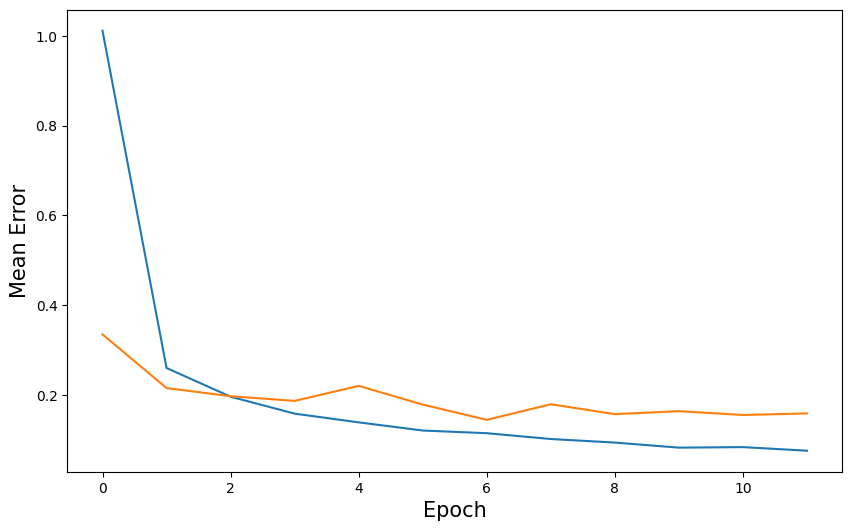

In [24]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='train')
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Mean Error', fontsize=15)

Veamos un ejemplo de predicción.

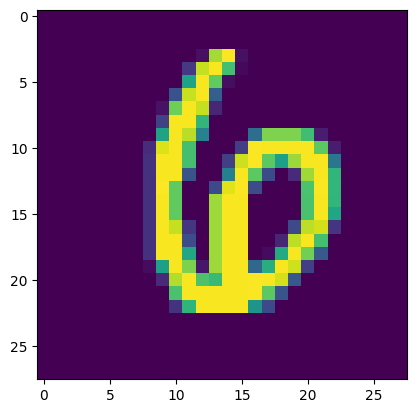

In [25]:
plt.imshow(arr_data[65413])
plt.show()

In [26]:
prediccion = model.predict(arr_data[65413][np.newaxis,:,:])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


In [28]:
prediccion, np.argmax(prediccion)

(array([[6.3689455e-05, 1.6871480e-17, 3.4175205e-09, 1.8214785e-09,
         2.8253993e-07, 9.8479006e-07, 9.9993503e-01, 1.6562814e-35,
         1.6150622e-08, 3.8932520e-12]], dtype=float32),
 6)

Noten que la capa softmax entrega números no enteros en sus salidas. Debemos considerar que la red entrega probabilidades de que la entrada sea efectivamente de alguna clase, por ende tomamos aquella clase que tenga la mayor probabilidad como predicción.

Ahora evaluemos todo el dataset de testeo.

In [30]:
all_predictions = model.predict(data_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [38]:
enteros = np.argmax(all_predictions, axis=1)
enteros_OHE = OHE.transform(enteros.reshape(-1,1))

In [47]:
aciertos = 0
for i in range(10000):
  if np.sum(enteros_OHE[i,:] == labels_test[i,:]) == 10:
    aciertos += 1

print(f'La red clasificó bien {aciertos} de un total de 10000 ejemplos del test.')

La red clasificó bien 9651 de un total de 10000 ejemplos del test.
